Source: Varvara Vetrova and Sheldon Coup (MSc, UC)

We will train several models here to classify images of digits from the MNIST dataset. We will see how choice of optimisation algorithm, batch size and learning rate influences the results of our model. 

# Importing needed libraries

Here we just import libraries from which we will need functions later. Please have a look at [Keras](https://Keras.io)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Utility functions
We created this function in order to help us to display loss function value and accuracy of our neural network model

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Main section

We will be using the MNIST dataset, which is built into Keras.
[MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


First of all we need to know what the size of the data we are dealing with is. \\
x_train, y_train, x_test and y_test are all numpy arrays, so we can just have a look at the shape attribute of each of them.
[More info on Numpy](https://www.numpy.org/)

In [ ]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


Let's display one image from MNIST

You will see a digit 5


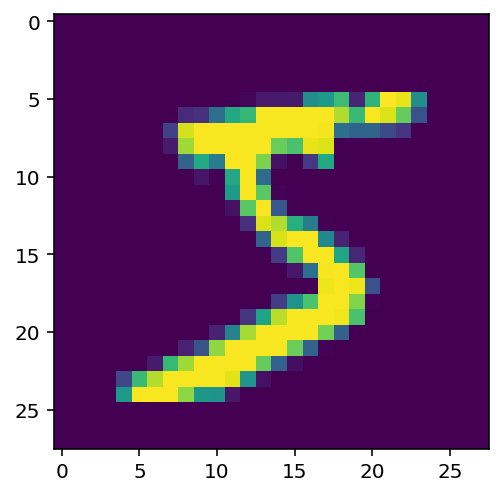

In [ ]:
plt.imshow(x_train[0])

This shows that we have 28 * 28 dimensional images with 60000 training images and 10000 testing images. \\
Next, in order to use a fully connected network to classify the images we need to convert these 28 * 28 images into vectors. \\
This can be done easily using the reshape function in numpy. [See this manual for more information of reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) \\
Additionally, as the inputs are images, we will rescale the vector values to be between 0 and 1 (rather than between 0 and 255). It will help our models to learn.

In [ ]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


The final step in the data preparation is to convert the integer labels (target labels, what we want to predict) to one-hot encoded labels. \\
We convert labels "0", "1",...,"9" into vectors 1000000, 0100000,...,0000001. \\
Keras has a built in function that does this named to_categorical. \\
Be careful here, if you run this section of code more than once then you might one-hot-encode your one-hot-encoded labels!

In [ ]:
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)


Next we want to initialize our neural network model. \\
We start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers. \\
Please note that we don't explicitly add an input layer! It's a parameter of the first Dense Layer - input_shape.
Here we will be starting with a simple network with just a single hidden layer with 32 neurons. \\
Make sure you set the size of the output layer to be the number of classes that we are trying to predict! \\
We can have a look at out model using the model.summary() function.

In [ ]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


**Can you pinpoint why we have that particular number of parameters?**
**It's a ten class classification problem. What accuracy would you expect from a model which just picks a class at random in this case?**

Before training we must compile out model and select three important things:

1.   Paramaters of  optimisitation procedure to use. For now we will be using simple SGD - gradient descent, this optimizer is the first one to ever be used in practice and the most simple to understand. Please not that SGD term in Keras is different from the lectures. By default in Keras, SGD is a gradient descent  with a fixed learning rate.  
There are lots of other options for optimisation that we could look at though, for example using adaptive learning rate RMSprop, Adam, Adadelta, etc

2.   What loss function to use. For classification this loss function is almost always 'categorical_crossentropy', but if we were doing regression then we would be using a different loss function. Which one?

3. Finally, a metric. Generally, for classification, we are looking at the accuracy of the model. However we could also look at things like top k accuracy. We don't use it however to train it, only for evaluation.


In [ ]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

Finally, we are able to train our model to do some classification. Here we must select how long we wish to train for (epochs) and the mini-batch size. Please not that we reserved 10 percent of our dataset here for validaiton. 

In [ ]:

history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2885 - accuracy: 0.2159 - val_loss: 1.9391 - val_accuracy: 0.6385
Epoch 2/5
422/422 [==============================] - 1s 2ms/step - loss: 1.8734 - accuracy: 0.6431 - val_loss: 1.6151 - val_accuracy: 0.7377
Epoch 3/5
422/422 [==============================] - 1s 2ms/step - loss: 1.5746 - accuracy: 0.7157 - val_loss: 1.3492 - val_accuracy: 0.7820
Epoch 4/5
422/422 [==============================] - 1s 2ms/step - loss: 1.3381 - accuracy: 0.7506 - val_loss: 1.1457 - val_accuracy: 0.8137
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.1503 - accuracy: 0.7808 - val_loss: 0.9943 - val_accuracy: 0.8393


Test loss: 1.02
Test accuracy: 0.807


<Figure size 576x432 with 0 Axes>

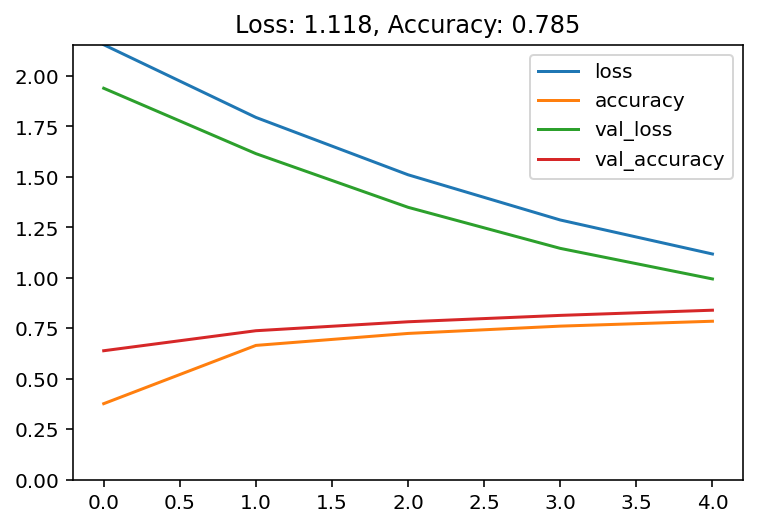

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Clearly we can see that our model was getting better during training but didn't have enough time to reach its full potential! Let's restart and train it for a bit longer and see if we can get better results. We can do it by changing number of epochs.


In [ ]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
422/422 [==============================] - 2s 3ms/step - loss: 2.2450 - accuracy: 0.2529 - val_loss: 1.9321 - val_accuracy: 0.6665
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 1.8637 - accuracy: 0.6586 - val_loss: 1.6038 - val_accuracy: 0.7500
Epoch 3/50
422/422 [==============================] - 1s 2ms/step - loss: 1.5616 - accuracy: 0.7182 - val_loss: 1.3387 - val_accuracy: 0.7895
Epoch 4/50
422/422 [==============================] - 1s 2ms/step - loss: 1.3268 - accuracy: 0.7561 - val_loss: 1.1365 - val_accuracy: 0.8145
Epoch 5/50
422/422 [==============================] - 1s 2ms/step - loss: 1.1472 - accuracy: 0.7777 - val_loss: 0.9857 - val_accuracy: 0.8320
Epoch 6/50
422/422 [==============================] - 1s 2ms/step - loss: 1.0119 - accuracy: 0.7964 - val_loss: 0.8722 - val_accuracy: 0.8495
Epoch 7/50
422/422 [==============================] - 1s 2ms/step - loss: 0.9116 - accuracy: 0.8092 - val_loss: 0.7847 - val_accuracy: 0.8592
Epoch 

Let's see what the loss and accuracy curves look like.

<Figure size 576x432 with 0 Axes>

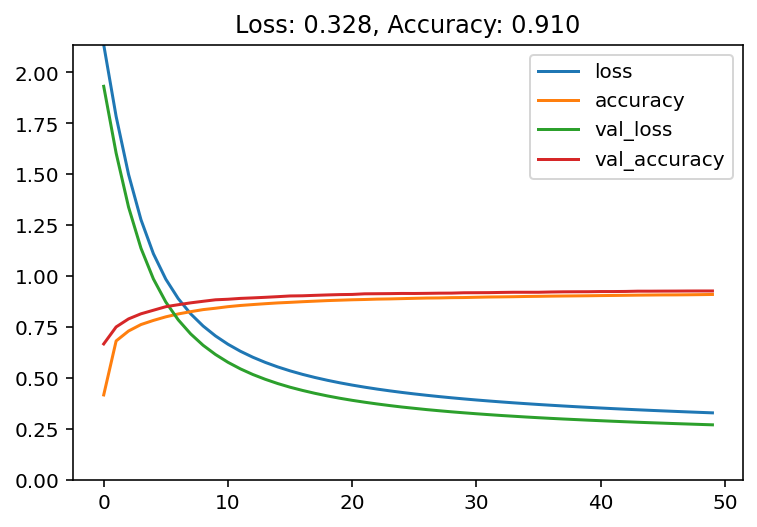

In [ ]:
plot_loss_accuracy(history)

That's looking a bit better. Now we can test this trained model on our test set to get the final test result.

In [ ]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.311
Test accuracy: 0.915


Now lets try out *batch* training, where we train using the entire training set each step.

In [ ]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 2.4395 - accuracy: 0.0890 - val_loss: 2.4274 - val_accuracy: 0.0900
Epoch 2/50
1/1 [==============================] - 0s 316ms/step - loss: 2.4342 - accuracy: 0.0888 - val_loss: 2.4223 - val_accuracy: 0.0898
Epoch 3/50
1/1 [==============================] - 0s 299ms/step - loss: 2.4290 - accuracy: 0.0887 - val_loss: 2.4174 - val_accuracy: 0.0897
Epoch 4/50
1/1 [==============================] - 0s 296ms/step - loss: 2.4241 - accuracy: 0.0885 - val_loss: 2.4127 - val_accuracy: 0.0897
Epoch 5/50
1/1 [==============================] - 0s 299ms/step - loss: 2.4193 - accuracy: 0.0884 - val_loss: 2.4081 - val_accuracy: 0.0888
Epoch 6/50
1/1 [==============================] - 0s 330ms/step - loss: 2.4146 - accuracy: 0.0882 - val_loss: 2.4037 - val_accuracy: 0.0883
Epoch 7/50
1/1 [==============================] - 0s 336ms/step - loss: 2.4101 - accuracy: 0.0879 - val_loss: 2.3994 - val_accuracy: 0.0878
Epoch 8/50
1/1 [=======

<Figure size 576x432 with 0 Axes>

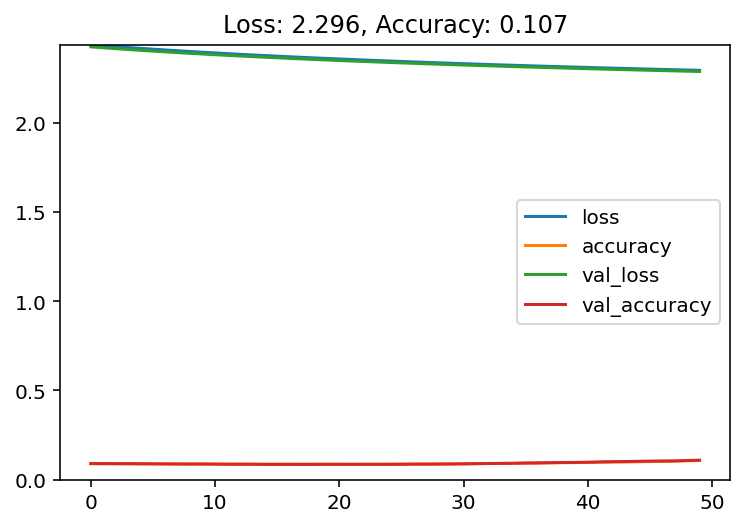

In [ ]:
plot_loss_accuracy(history)

Notice how the loss function is reduced much less per each epoch in comparison with  the mini-batch gradient descent.  It's because we update gradient only once per apoch  in batch training but we update it 54000/128=421 times per epoch in the case of mini-batch gradient descent. You will also see that the loss function might look a bit jittery for the mini-batch case. This is because we estimate gradient, and each iteration we might have slightly different estimate \\
Using the whole dataset at each step seems to be converging a bit slow than we would like and we don't have all day to wait around for things to train, so lets try restarting using a increased learning rate.

The default SGD learning rate is 0.01. Let's change it to 0.1

In [ ]:
model = build_basic_model()
model.compile(SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 [==============================] - 1s 933ms/step - loss: 2.3938 - accuracy: 0.1402 - val_loss: 2.3690 - val_accuracy: 0.1422
Epoch 2/50
1/1 [==============================] - 0s 300ms/step - loss: 2.3623 - accuracy: 0.1463 - val_loss: 2.3419 - val_accuracy: 0.1515
Epoch 3/50
1/1 [==============================] - 0s 307ms/step - loss: 2.3363 - accuracy: 0.1539 - val_loss: 2.3191 - val_accuracy: 0.1635
Epoch 4/50
1/1 [==============================] - 0s 301ms/step - loss: 2.3145 - accuracy: 0.1639 - val_loss: 2.2995 - val_accuracy: 0.1743
Epoch 5/50
1/1 [==============================] - 0s 343ms/step - loss: 2.2958 - accuracy: 0.1755 - val_loss: 2.2824 - val_accuracy: 0.1883
Epoch 6/50
1/1 [==============================] - 0s 343ms/step - loss: 2.2794 - accuracy: 0.1874 - val_loss: 2.2671 - val_accuracy: 0.2042
Epoch 7/50
1/1 [==============================] - 0s 341ms/step - loss: 2.2649 - accuracy: 0.1998 - val_loss: 2.2533 - val_accuracy: 0.2173
Epoch 8/50
1/1 [====

<Figure size 576x432 with 0 Axes>

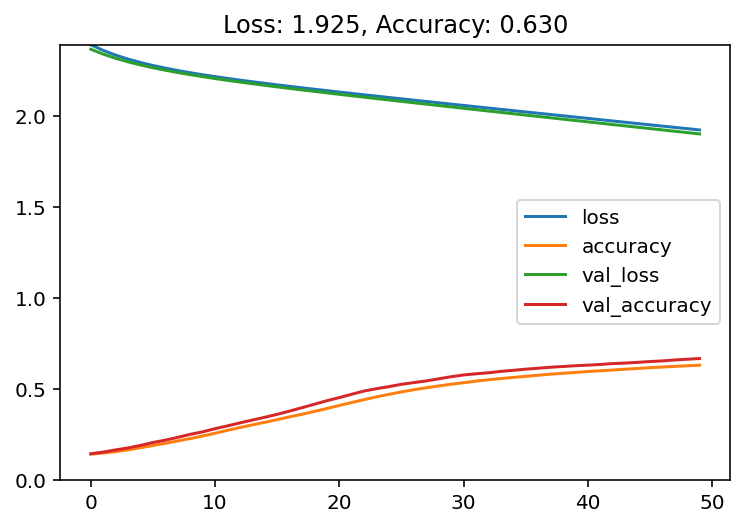

In [ ]:
plot_loss_accuracy(history)

In [ ]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 1.91
Test accuracy: 0.651


That is an improvement, but what if we move past a simple fixed learning rate like  in the SGD optimizer. Lets have a look at Adam method. This method automatically adapts learning rate during training process. It's no longer fixed.
We are going to take the batch size back down to 256 now, feel free to experiment and put your own batch size in.

In [ ]:
model = build_basic_model()
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 1s 4ms/step - loss: 1.7057 - accuracy: 0.5670 - val_loss: 0.7116 - val_accuracy: 0.8880
Epoch 2/50
211/211 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.8673 - val_loss: 0.4192 - val_accuracy: 0.9153
Epoch 3/50
211/211 [==============================] - 1s 3ms/step - loss: 0.4499 - accuracy: 0.8958 - val_loss: 0.3205 - val_accuracy: 0.9273
Epoch 4/50
211/211 [==============================] - 1s 3ms/step - loss: 0.3623 - accuracy: 0.9077 - val_loss: 0.2724 - val_accuracy: 0.9337
Epoch 5/50
211/211 [==============================] - 1s 3ms/step - loss: 0.3143 - accuracy: 0.9172 - val_loss: 0.2451 - val_accuracy: 0.9385
Epoch 6/50
211/211 [==============================] - 1s 3ms/step - loss: 0.2816 - accuracy: 0.9236 - val_loss: 0.2257 - val_accuracy: 0.9417
Epoch 7/50
211/211 [==============================] - 1s 3ms/step - loss: 0.2558 - accuracy: 0.9305 - val_loss: 0.2112 - val_accuracy: 0.9435
Epoch 

<Figure size 576x432 with 0 Axes>

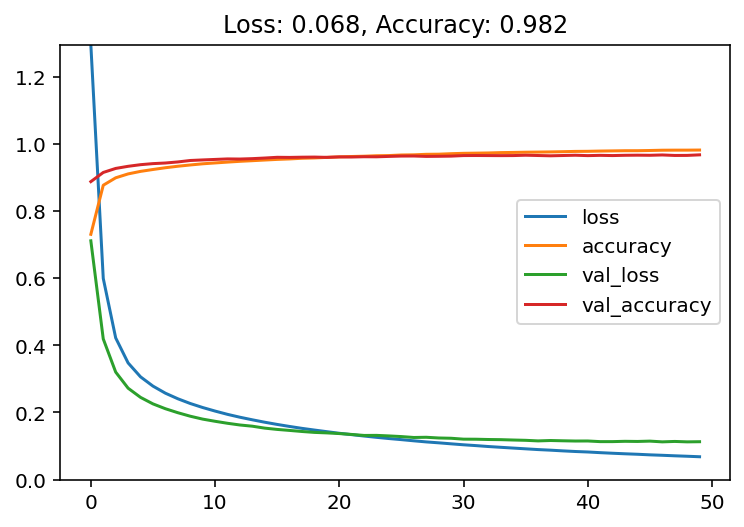

In [ ]:
plot_loss_accuracy(history)

In [ ]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.124
Test accuracy: 0.964


That works quite well, Adam allows for more complex learning rate updates than in the SGD optimizer.  It's used frequently in practise. 
What if we bump up the starting learning rate on this Adam optimizer?



In [ ]:
model = build_basic_model()
model.compile(Adam(lr=5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 1s 4ms/step - loss: 21.8904 - accuracy: 0.2242 - val_loss: 8.8206 - val_accuracy: 0.2650
Epoch 2/50
211/211 [==============================] - 1s 4ms/step - loss: 8.0782 - accuracy: 0.2291 - val_loss: 5.6791 - val_accuracy: 0.1433
Epoch 3/50
211/211 [==============================] - 1s 4ms/step - loss: 8.7111 - accuracy: 0.1521 - val_loss: 4.0131 - val_accuracy: 0.2060
Epoch 4/50
211/211 [==============================] - 1s 3ms/step - loss: 5.2064 - accuracy: 0.2075 - val_loss: 2.8277 - val_accuracy: 0.2705
Epoch 5/50
211/211 [==============================] - 1s 4ms/step - loss: 3.2162 - accuracy: 0.2362 - val_loss: 1.9881 - val_accuracy: 0.2807
Epoch 6/50
211/211 [==============================] - 1s 4ms/step - loss: 3.5059 - accuracy: 0.2630 - val_loss: 4.9549 - val_accuracy: 0.1992
Epoch 7/50
211/211 [==============================] - 1s 4ms/step - loss: 9.1789 - accuracy: 0.2031 - val_loss: 10.9206 - val_accuracy: 0.2430
Epoc

<Figure size 576x432 with 0 Axes>

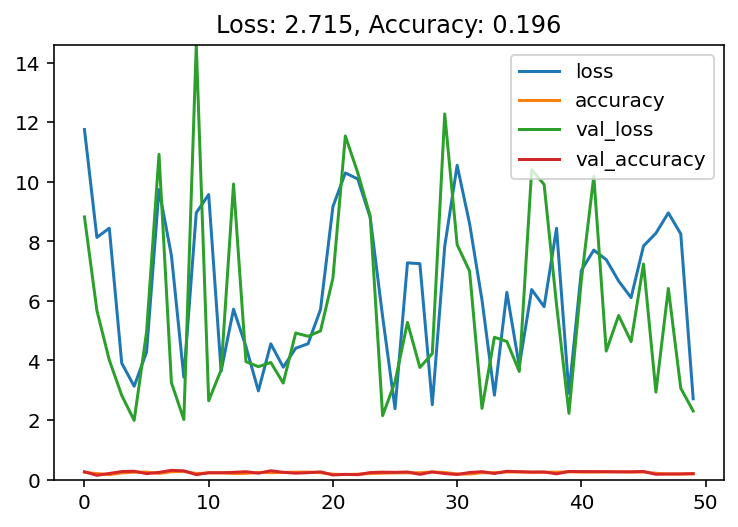

In [ ]:
plot_loss_accuracy(history)

So this is the other end of the scale when it comes to tuning learning rates, this is far too high and the model is actually getting worse several times during training. We want models to train as quickly as possible so we don't waste our time, but if we get overzealous and set the learning rate too high we might not be able to train at all! Usually we can tell from the loss curve when this is the case though.

There are many methods which update learning rate in a smart way during training process. 
Lets try using an optimizer with momentum - it's almost like Adam, it still adapts learning rate in the couse of training but with a bit of twist. We will be using the 'Nadam ' optimizer here 
Nadam = N(esterov momentum) Adam

In [ ]:
model = build_basic_model()
model.compile('nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 1s 4ms/step - loss: 1.7974 - accuracy: 0.4786 - val_loss: 0.7294 - val_accuracy: 0.8887
Epoch 2/50
211/211 [==============================] - 1s 4ms/step - loss: 0.6915 - accuracy: 0.8666 - val_loss: 0.4281 - val_accuracy: 0.9137
Epoch 3/50
211/211 [==============================] - 1s 4ms/step - loss: 0.4630 - accuracy: 0.8929 - val_loss: 0.3274 - val_accuracy: 0.9235
Epoch 4/50
211/211 [==============================] - 1s 4ms/step - loss: 0.3696 - accuracy: 0.9082 - val_loss: 0.2780 - val_accuracy: 0.9322
Epoch 5/50
211/211 [==============================] - 1s 4ms/step - loss: 0.3214 - accuracy: 0.9164 - val_loss: 0.2480 - val_accuracy: 0.9357
Epoch 6/50
211/211 [==============================] - 1s 4ms/step - loss: 0.2952 - accuracy: 0.9186 - val_loss: 0.2278 - val_accuracy: 0.9400
Epoch 7/50
211/211 [==============================] - 1s 4ms/step - loss: 0.2665 - accuracy: 0.9268 - val_loss: 0.2123 - val_accuracy: 0.9427
Epoch 

Test loss: 0.132
Test accuracy: 0.961


<Figure size 576x432 with 0 Axes>

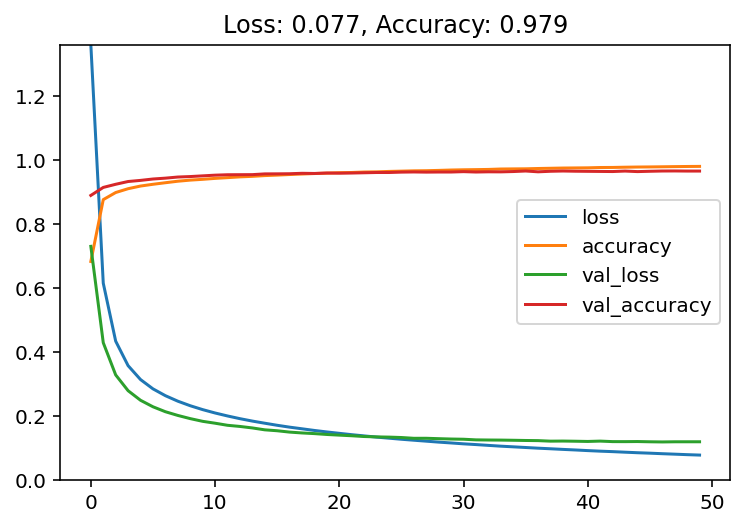

In [ ]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

All of these models have *in general* converged to ~92 % accuracy. This gives an indication that this is likely to be the maximum capacity of the neural network structure that we have constructed. Considering that this model has just one hidden layer, it is getting pretty solid performance. Lets try  to experiment with a model that is a little bit more complex and see if we can get a little bit higher performance. 
One thing to note about creating more complex models is the seriously diminishing returns, in most cases each new layer you add with contribute less to the performance than previous layers. I.e the difference between a 1 and 2 layer model is much bigger than the difference between a 10 and 11 layer model.


Below I have provided two functions, one creates a model with an additional layer, one has a dropout layer in it. Dropout acts as a regularisation method, it randomly throws away neurons from the model during trainig with a rate r.
 Select an optimizer, leanring rate and batch size and see if you can beat any of the test accuracies that we managed to get above.

In [ ]:
def build_dropout_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.2))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=64, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=32, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model



Below is a Python structure which allows you to choose a learning rate update method

In [ ]:
opt_dict = {'nadam':Nadam,
            'adam':Adam,
            'sgd':SGD,
            'rmsprop':RMSprop,
            'adadelta':Adadelta,
            'adagrad':Adagrad}

If you want to know what the default learning rate values are for the optimizers have a look here: https://keras.io/optimizers/

**Try to train your own model**

In [ ]:
model = build_dropout_model()
# or
model = build_deeper_model()
# or make your own model! (recommended)

# set all the following values yourself
optimizer_name  = 'sgd' # see Python dictionary in the previous cell. Any of the following: nadam, adam, sgd, rmsprop, adadelta, adagrad
learning_rate = 0 # some number above 0. What happens if you put zero in?
batch_size = 1 #some integer
training_epochs = 1 # some integer


# selects optimizer and sets learning rate
optimizer = opt_dict[optimizer_name](lr=learning_rate)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs, verbose=True, validation_split=.1)

54000/54000 [==============================] - 62s 1ms/step - loss: 2.4323 - accuracy: 0.0840 - val_loss: 2.4288 - val_accuracy: 0.0847


Can you write here what model, optimisation algorithm, learning rate update strategy, batch size and number of epochs did you try.

Let's evaluate your model now!

Test loss: 2.43
Test accuracy: 0.083


<Figure size 576x432 with 0 Axes>

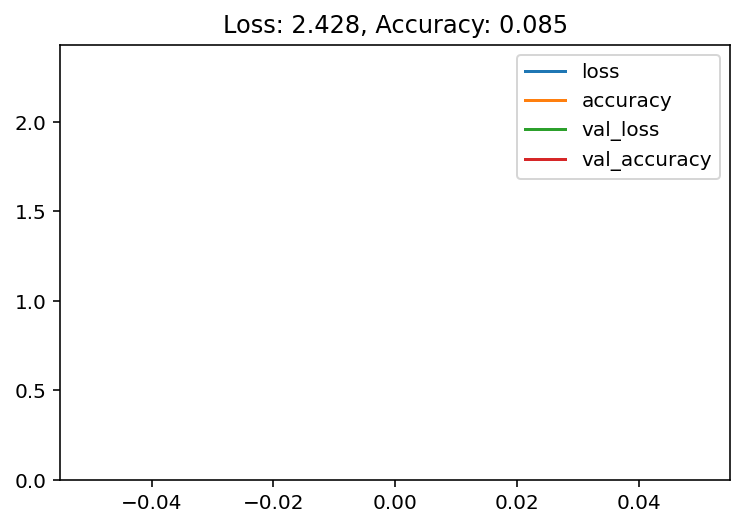

In [ ]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')